## ANALYSE DE SENSIBILITE DU MODEL HYDRO R-NIAYES 2040

In [24]:
create_folder=function(x,path=getwd()){
    
        for (f in x){
            
            folder<-file.path(path, f)

        if (!dir.exists(folder)){
            dir.create(folder)
            print(paste(f,"has been created!"))
        } else {
        print(paste(folder,"already exists!"))}
        }
}

In [25]:
rcsv_sep=function(file_path){
    L <- readLines(file_path, n = 1)
    if (grepl(";", L)) read.csv2(file_path) else read.csv(file_path)
    }

In [26]:
normaliz_zero<-function(x){
    x<-na.omit(x)
    min<-min(x)
    max<-max(x)
    
    val<-as.numeric(lapply(x,function(y) (y-min)/(max-min)))
return(val)
}

### Méthode de Morris

### 1-  LE PLAN DE MORRIS

### a-)  Plan d'expérience

- les paramètres d'entrée

In [27]:
#### la table des RMSE
rmse<-rcsv_sep('data/tableau_rsme.csv')[-1]

#names(rmse)[4:7]<-c("varperm","varstock","nbiterations","consourb")
rmse[3:7]<-data.frame(lapply(rmse[3:7],as.numeric))

In [28]:
set<-subset(rmse,resolution==300|
             resolution==500|
             resolution==700|
             resolution==900)

In [29]:
rmse_norm<-set
rmse_norm[3:6]<-data.frame(sapply(set[3:6],normaliz_zero))

head(set[c(3:8,10)],3)
head(rmse_norm[c(3:8,10:12)],3)

consourb moyirrigculture varstock resolution Y_mean   Y_median zone       
1 0.015    11.7            -30      900        5.674507 4.550655 mean_indice
2 0.015     9.7            -30      900        5.682676 4.562606 mean_indice
3 0.015     9.7              0      900        5.628428 4.496086 mean_indice

consourb moyirrigculture varstock resolution Y_mean   Y_median zone       
1 0        0.6666667       0.0      1          5.674507 4.550655 mean_indice
2 0        0.3333333       0.0      1          5.682676 4.562606 mean_indice
3 0        0.3333333       0.5      1          5.628428 4.496086 mean_indice
  rmse_agg_dgpz rmsle    
1 0.6630594     0.1218844
2 0.6604217     0.1223619
3 0.6771214     0.1238499

In [30]:
unique(rmse$moyirrigculture)

[1] 11.7  9.7 13.7  7.7

#### b-) Plan One At Time (OAT)

In [31]:
pPlan<-sapply(rmse[3:6],unique)

pPlan<- data.frame(lapply(pPlan, function(x) {
  x <- unlist(x)
  length(x) <- max(lengths(pPlan))
  return(x)
}))
pPlan

consourb moyirrigculture varstock resolution
1 0.015    11.7            -30      900       
2 0.030     9.7              0      700       
3    NA    13.7             30      500       
4    NA     7.7             NA      300

In [32]:
poat<-rmse_norm[c(3:6,11:12)]
head(poat,3)

consourb moyirrigculture varstock resolution rmse_agg_dgpz rmsle    
1 0        0.6666667       0.0      1          0.6630594     0.1218844
2 0        0.3333333       0.0      1          0.6604217     0.1223619
3 0        0.3333333       0.5      1          0.6771214     0.1238499

#### c-) méthode de Morris: Le plan de morris avec échantillonnage radial itéré

In [33]:
set.seed(123)

i<-0
EE<-c()
PARAM<-c()
choc<-c()
response<-c()

while (i<10){
    i<- i+1
    t<-c()
    T<-0
    
        #premier plan OAT

            ##trier au hasard l'état initial des paramètre du plan OAT
            L0<-sample(dim(poat)[1],1)
            input0 <- poat[L0,1:4]

            ##appel initial au model (réponse du model au set initial de paramètres)
            output0 <- poat[L0,5]

        while (T<10){
            #effets elementaire
                ##tirage aléatoire pour modification d'une entrée
                to<-sample(length(input0),1)

                ##modification du parametre choqué:
                input1 <- input0

                c<-0
            
                lt<-unique(unlist(na.omit(poat[to])))
                lt<-as.list(lt[-which(lt==input0[[to]])])
                while (c<1){
                    chg<-sample(lt,1)[[1]]
                    input1[to]<-chg

                    input1<-subset(poat, 
                    consourb==input1[["consourb"]] &
                    moyirrigculture==input1[["moyirrigculture"]] &
                    varstock==input1[["varstock"]] &
                    resolution==input1[["resolution"]] )

                    ##le pas de changement
                    d<-(chg-input0[to])

                    if (NROW(input1)>0){
                        c<-1}
                    if (NROW(input1)==0){input1 <- input0
                                        lt<-lt[-which(lt==chg)]}
                }
            

                ##appel au model choqué
                output1 <- input1[,5]
                input1 <- input1[L0,1:4]

                ## effet élémentaire EE
                EE1<-(output1-output0)/d
                EE <-c (EE,round(EE1,3))
                PARAM<- c(PARAM,names(input1)[to])
                choc<-c(choc,d)
                response<-c(response,round((output1-output0),3))
                t<-c(t,to)
                T<-sum(unique(t))
    }
}

In [34]:
ee_morris <- data.frame(cbind(unlist(PARAM),
                              unlist(EE),
                              unlist(choc),
                              unlist(response)))
rownames(ee_morris) <-NULL 
ee_morris[2:4]<-sapply(ee_morris[2:4],as.numeric)
ee_morris[1]<-sapply(unlist(ee_morris[1]),as.factor)
names(ee_morris) <- c("parametres","effet_elementaire","delta_X","delta_Y")

In [35]:
morris<-pPlan[which(pPlan[1]=="R"),]

In [36]:
for (j in 1:4){
    morris["mean_effect",j]<-round(mean((ee_morris[which(ee_morris[1]==names(morris)[j]),2]),
                                                 na.rm=TRUE),3)
    
    morris["mean_absolute_effect",j]<-round(mean(abs(ee_morris[which(ee_morris[1]==names(morris)[j]),2]),
                                                 na.rm=TRUE),3)
    
    morris["sd_effect",j]<-round(sd(ee_morris[which(ee_morris[1]==names(morris)[j]),2],
                                    na.rm=TRUE),3)
    
        morris["delta_X",j]<-round(mean(ee_morris[which(ee_morris[1]==names(morris)[j]),3],
                                    na.rm=TRUE),3)
    
        morris["delta_Y",j]<-round(mean(ee_morris[which(ee_morris[1]==names(morris)[j]),4],
                                    na.rm=TRUE),3)
}
morris<-t(morris)

In [37]:
morris

mean_effect mean_absolute_effect sd_effect delta_X delta_Y
consourb        -0.003      0.004                0.004      0.111   0.002 
moyirrigculture -0.013      0.019                0.020     -0.019   0.000 
varstock        -0.008      0.040                0.069      0.125   0.007 
resolution       0.379      0.393                0.179     -0.250  -0.088

In [38]:
plt<-data.frame(morris)

#### Plot morris Plan

In [39]:
rownames(plt)

[1] "consourb"        "moyirrigculture" "varstock"        "resolution"

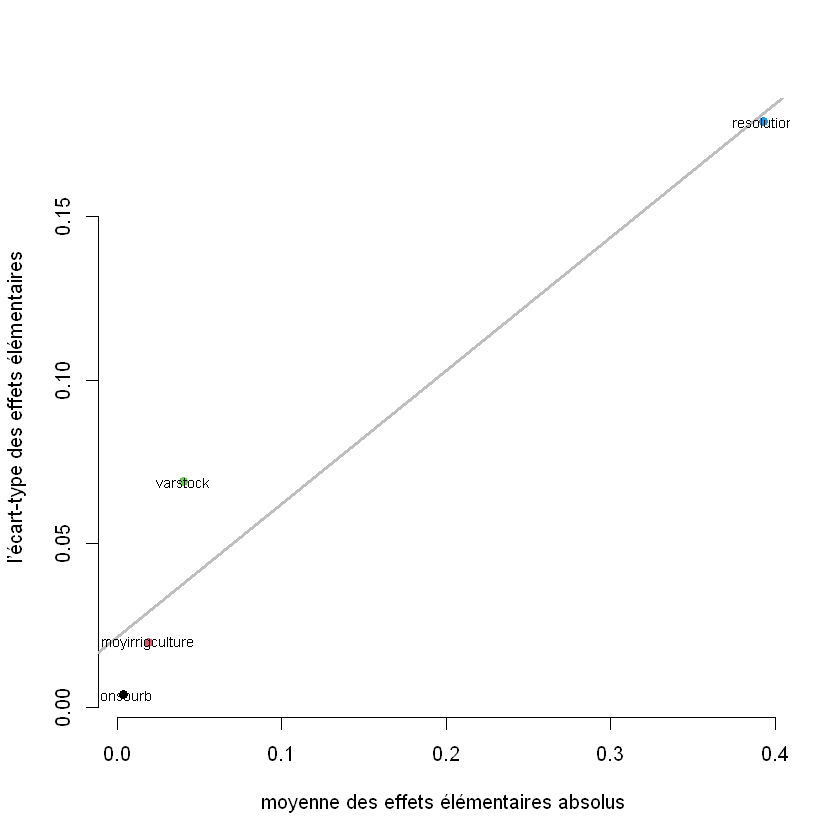

In [40]:
plot(x = plt$mean_absolute_effect,
     y = plt$sd_effect,
     pch = 16, frame = FALSE,
     xlab = "moyenne des effets élémentaires absolus", 
     ylab = "l’écart-type des effets élémentaires",
     col = c(1:5))
abline(lm(sd_effect ~ mean_absolute_effect,data=plt), col="grey", lwd=3)
#text(sd_effect ~ mean_effect, labels=rownames(plt),data=plt, cex=0.9, font=2)
text(plt$mean_absolute_effect,plt$sd_effect,labels=rownames(plt), cex= 0.7, offset = 10)

In [41]:
write.csv2(ee_morris, file = "output/effet_elementaire_morris.csv")

##### Rang Morris

In [42]:
rank<-data.frame(morris[,2:3])
rank$sum<-(rank$sd_effect+rank$mean_absolute_effect)
rank<-rank[order(rank$sum),]
rank$Rang_Morris<-sort(1:9,decreasing=TRUE)
rank<-rank[order(rank$Rang_Morris),-3]

In [44]:
rank

mean_absolute_effect sd_effect Rang_Morris
consourb        0.004                0.004     4          
moyirrigculture 0.019                0.020     3          
varstock        0.040                0.069     2          
resolution      0.393                0.179     1